# FAISS Vector Search Demo

This notebook demonstrates how to use the modular FAISS vector search implementation.

In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys

# Add the project directory to the path (if needed)
# sys.path.append('..')

# Import project modules
from dataset.synthetic_data import generate_sample_vectors, create_query_vector
from models.cosine_search import brute_force_cosine_search
from models.faiss_flat import faiss_flat_l2_search
from models.faiss_ivf import faiss_ivf_search, train_ivf_index, add_vectors_to_index, get_searched_regions
from utils.visualization import plot_vectors_3d, plot_vectors_with_regions, train_kmeans_get_centroids
from utils.evaluation import compare_search_results

## 1. Generate synthetic data

We'll generate some synthetic vector data for demonstration purposes. For visualization, we'll use 3D vectors.

Generating 1000 vectors with 3 dimensions...


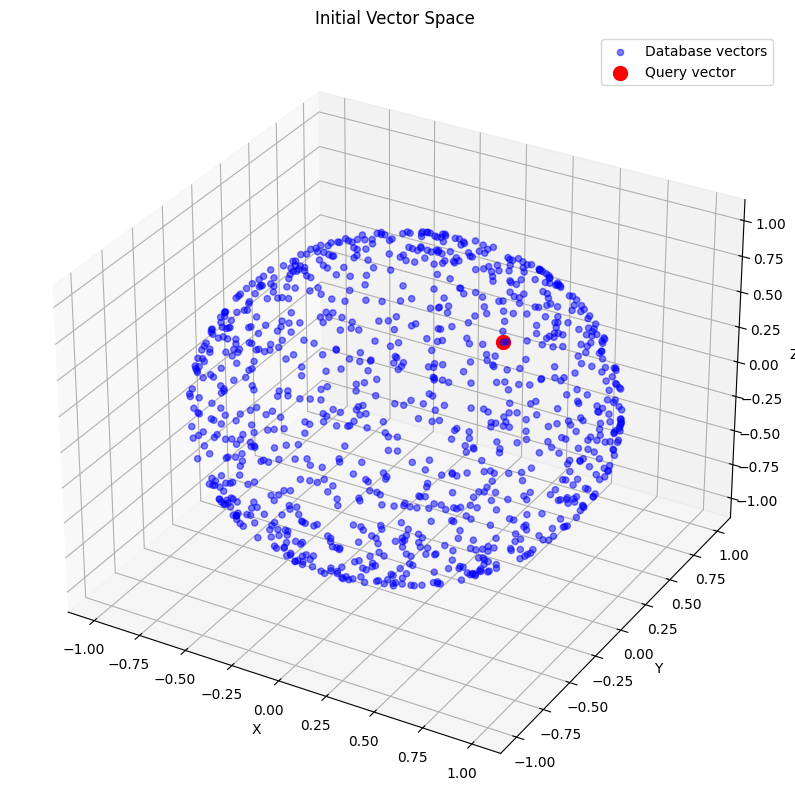

In [2]:
# Generate sample vectors
n_vectors = 1000
n_dimensions = 3  # 3D for visualization
k = 5  # Number of nearest neighbors to retrieve

print(f"Generating {n_vectors} vectors with {n_dimensions} dimensions...")
database_vectors = generate_sample_vectors(n_vectors, n_dimensions)

# Generate a query vector
query_vector = create_query_vector(n_dimensions)

# Visualize the initial vector space
plot_vectors_3d(database_vectors, query_vector, title="Initial Vector Space")

## 2. Brute Force Cosine Similarity Search

First, let's perform a brute force cosine similarity search to find the nearest neighbors.


Performing brute force cosine similarity search...
Brute force search time: 0.000173 seconds
Top 5 cosine similarity matches (indices): [  0 653  61 273 336]


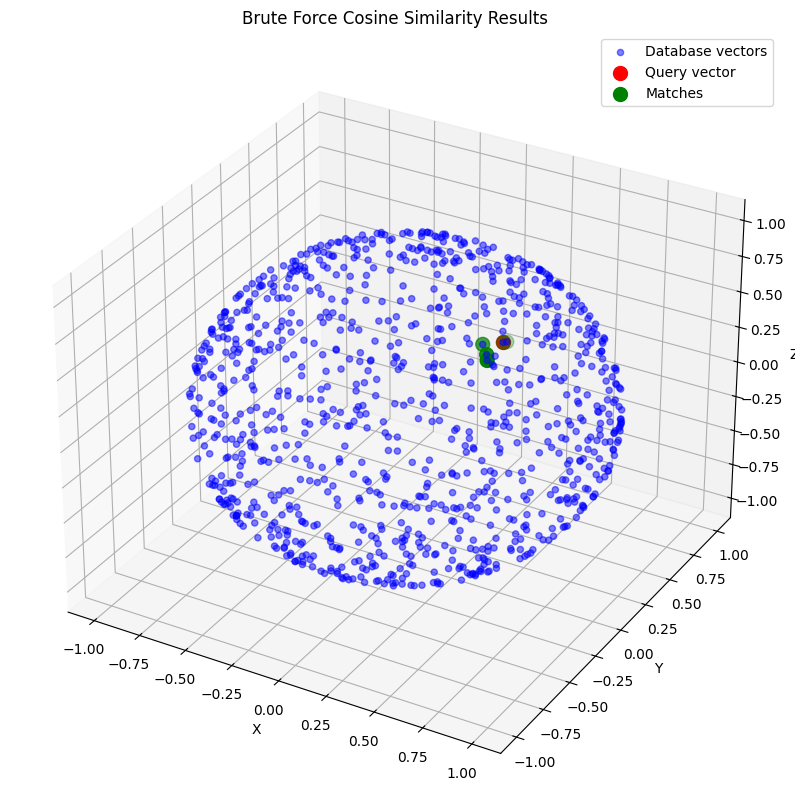

In [3]:
# Perform brute force cosine similarity search
print("\nPerforming brute force cosine similarity search...")
cosine_matches, cosine_time = brute_force_cosine_search(database_vectors, query_vector, k)
print(f"Brute force search time: {cosine_time:.6f} seconds")
print(f"Top {k} cosine similarity matches (indices): {cosine_matches}")

# Visualize cosine results
plot_vectors_3d(database_vectors, query_vector, cosine_matches, 
               "Brute Force Cosine Similarity Results")

## 3. FAISS Flat L2 Search

Next, let's use FAISS flat L2 search, which is still exact but faster than a manual implementation.


Performing basic FAISS L2 search...
FAISS L2 search time: 0.000180 seconds
Top 5 L2 distance matches (indices): [  0 653  61 273 336]


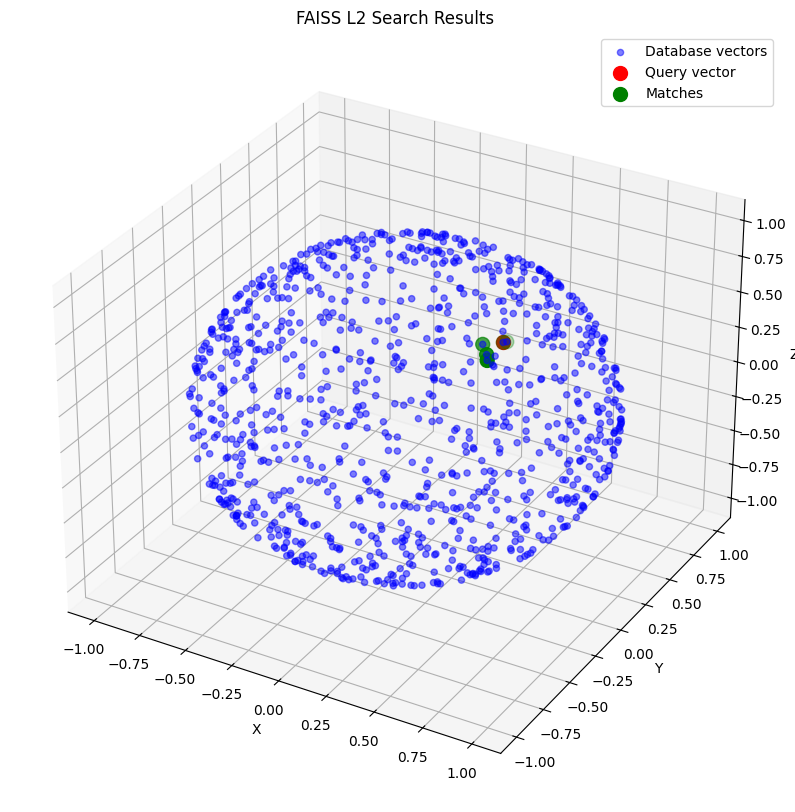

In [4]:
# Perform basic FAISS L2 search
print("\nPerforming basic FAISS L2 search...")
faiss_matches, faiss_time = faiss_flat_l2_search(database_vectors, query_vector, k)
print(f"FAISS L2 search time: {faiss_time:.6f} seconds")
print(f"Top {k} L2 distance matches (indices): {faiss_matches}")

# Visualize basic FAISS results
plot_vectors_3d(database_vectors, query_vector, faiss_matches, 
               "FAISS L2 Search Results")

## 4. FAISS IVF Search

Finally, let's use FAISS IVF search, which is an approximate method but much faster for large datasets.


Performing FAISS IVF search...
IVF training time: 0.040648 seconds
IVF adding time: 0.000088 seconds
IVF search time: 0.000027 seconds
Total IVF time: 0.040763 seconds
Top 5 IVF matches (indices): [  0 653  61 273 336]


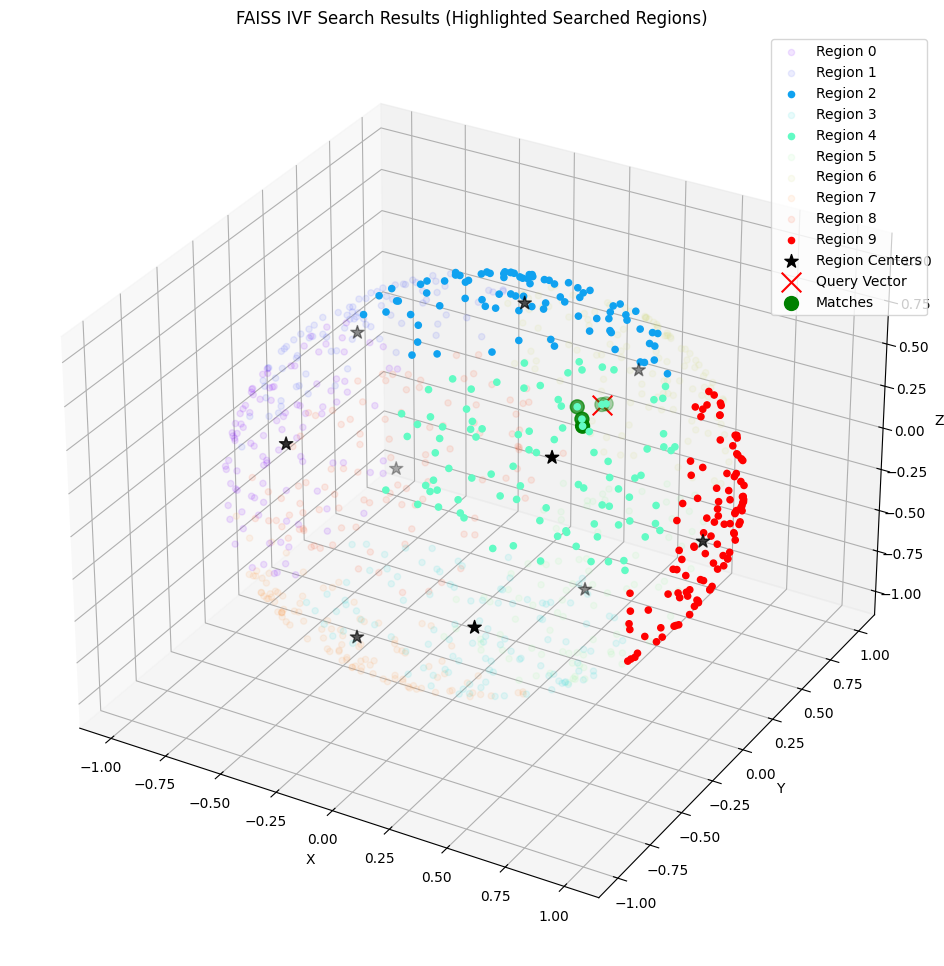

In [5]:
# Perform FAISS IVF search
print("\nPerforming FAISS IVF search...")
n_regions = 10
nprobe = 3

# Perform IVF search
ivf_matches, search_time, train_time, add_time = faiss_ivf_search(
    database_vectors, query_vector, k, n_regions, nprobe
)

print(f"IVF training time: {train_time:.6f} seconds")
print(f"IVF adding time: {add_time:.6f} seconds")
print(f"IVF search time: {search_time:.6f} seconds")
print(f"Total IVF time: {train_time + add_time + search_time:.6f} seconds")
print(f"Top {k} IVF matches (indices): {ivf_matches}")

# Get centroids for visualization
centroids = train_kmeans_get_centroids(database_vectors, n_regions)

# Get searched regions (approximate)
import faiss
searched_regions = get_searched_regions(query_vector.reshape(1, -1), centroids, nprobe)

# Visualize IVF results with regions
plot_vectors_with_regions(
    database_vectors, 
    centroids,
    query_vector, 
    ivf_matches,
    searched_regions,
    "FAISS IVF Search Results (Highlighted Searched Regions)"
)

## 5. Compare Results

Let's compare the results from the different search methods to see how similar they are.

In [6]:
# Compare results
print("\nComparing results between methods:")
common_matches_basic = compare_search_results(cosine_matches, faiss_matches, "Cosine", "FAISS Flat")
common_matches_ivf = compare_search_results(cosine_matches, ivf_matches, "Cosine", "FAISS IVF")
faiss_comparison = compare_search_results(faiss_matches, ivf_matches, "FAISS Flat", "FAISS IVF")


Comparing results between methods:
Comparing results between Cosine and FAISS Flat:
Common matches: 5 out of 5 (100.00%)
Common match indices: {0, 653, 336, 273, 61}
Comparing results between Cosine and FAISS IVF:
Common matches: 5 out of 5 (100.00%)
Common match indices: {0, 653, 336, 273, 61}
Comparing results between FAISS Flat and FAISS IVF:
Common matches: 5 out of 5 (100.00%)
Common match indices: {0, 653, 336, 273, 61}


## 6. Using a Trained Model

For production scenarios, you'll typically want to train a FAISS index once and then save it for future use. Here's how to do that.

In [7]:
# Import model saving/loading functions
from models.faiss_ivf import save_ivf_index, load_ivf_index

# Directory to save the model
os.makedirs("trained_models", exist_ok=True)
model_path = "trained_models/demo_ivf_index"

# Train and save a model
print("Training and saving IVF index...")
small_vectors = generate_sample_vectors(1000, 64)  # Smaller vectors for demo

# Train index
index, train_time = train_ivf_index(small_vectors, n_regions=10)
add_time = add_vectors_to_index(index, small_vectors)

# Save index to disk
metadata = {
    "n_vectors": len(small_vectors),
    "dimensions": small_vectors.shape[1],
    "n_regions": 10,
    "date_created": time.strftime("%Y-%m-%d %H:%M:%S")
}
save_ivf_index(index, small_vectors, model_path, metadata)

# Later, load the index
print("Loading saved IVF index...")
loaded_index, loaded_vectors, loaded_metadata = load_ivf_index(model_path, set_nprobe=3)

print(f"Loaded index with {loaded_index.ntotal} vectors")
print(f"Metadata: {loaded_metadata}")

# Create a new query
test_query = create_query_vector(n_dimensions=loaded_vectors.shape[1])

# Perform search with loaded index
distances, indices = loaded_index.search(test_query.reshape(1, -1), k=5)
print(f"Search results with loaded index: {indices[0]}")

Training and saving IVF index...
Saved FAISS IVF index to trained_models/demo_ivf_index
Loading saved IVF index...
Loaded index with 1000 vectors
Metadata: {'n_vectors': 1000, 'dimensions': 64, 'n_regions': 10, 'date_created': '2025-04-13 12:22:11'}
Search results with loaded index: [  0   5 929  71 456]


## 7. Performance Comparison with Larger Dimensions

Let's compare the performance of the different methods on higher-dimensional vectors, which is more typical for real-world embedding use cases.

In [ ]:
# Test with higher dimensional vectors
print("\nTesting with higher dimensions...")
dimension = 256  # Typical embedding dimension
n_vectors_high_dim = 10000000
n_queries = 100  # Smaller number for demonstration

# Generate vectors and queries
high_dim_vectors = generate_sample_vectors(n_vectors_high_dim, dimension)
high_dim_queries = generate_sample_vectors(n_queries, dimension)

# Dictionary to store results
results = {
    'method': [],
    'time': []
}

# 1. Brute Force Cosine
start_time = time.time()
for query in high_dim_queries:
    _, _ = brute_force_cosine_search(high_dim_vectors, query, k)
brute_force_time = (time.time() - start_time) / n_queries
results['method'].append('Brute Force Cosine')
results['time'].append(brute_force_time)

# 2. FAISS Flat L2
start_time = time.time()
for query in high_dim_queries:
    _, _ = faiss_flat_l2_search(high_dim_vectors, query.reshape(1, -1), k)
faiss_flat_time = (time.time() - start_time) / n_queries
results['method'].append('FAISS Flat L2')
results['time'].append(faiss_flat_time)

# 3. FAISS IVF
n_regions = 100  # More regions for larger dataset
nprobe = 10      # Search more regions for better accuracy

# Train IVF index
index, train_time = train_ivf_index(high_dim_vectors, n_regions)
add_time = add_vectors_to_index(index, high_dim_vectors)
index.nprobe = nprobe

start_time = time.time()
for query in high_dim_queries:
    index.search(query.reshape(1, -1), k)
faiss_ivf_time = (time.time() - start_time) / n_queries
results['method'].append('FAISS IVF')
results['time'].append(faiss_ivf_time)

print(f"Average times per query (seconds):")
for i, method in enumerate(results['method']):
    print(f"{method}: {results['time'][i]:.6f}")


Testing with higher dimensions...


In [ ]:
# Create a bar chart to compare times
plt.figure(figsize=(10, 6))
plt.bar(results['method'], results['time'])
plt.ylabel('Time per query (seconds)')
plt.title('Search Time Comparison (128 dimensions, 10,000 vectors)')
plt.yscale('log')  # Log scale for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations
for i, time_val in enumerate(results['time']):
    plt.text(i, time_val, f'{time_val:.6f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Working with Parquet Files

If you have embeddings stored in parquet files, you can load them using the `parquet_loader` module.

In [ ]:
# Import parquet loader functions
from dataset.parquet_loader import load_embeddings_from_parquet

# This is just an example - replace with your actual parquet file path
# parquet_path = "path/to/your/embeddings.parquet"

# For demonstration, let's create a dummy parquet file with embeddings
import pandas as pd

# Create some dummy embeddings
n_samples = 100
embedding_dim = 32
dummy_embeddings = generate_sample_vectors(n_samples, embedding_dim)

# Create a DataFrame with embeddings as a column
df = pd.DataFrame({
    'id': [f'doc_{i}' for i in range(n_samples)],
    'embeddings': [vec.tolist() for vec in dummy_embeddings]
})

# Save to a temporary parquet file
temp_parquet = "temp_embeddings.parquet"
df.to_parquet(temp_parquet)

print(f"Created temporary parquet file with {n_samples} embeddings")

# Load embeddings from the parquet file
try:
    loaded_embeddings = load_embeddings_from_parquet(temp_parquet)
    print(f"Loaded {len(loaded_embeddings)} embeddings with dimension {loaded_embeddings.shape[1]}")
    
    # Search using the loaded embeddings
    query = create_query_vector(embedding_dim)
    matches, _ = faiss_flat_l2_search(loaded_embeddings, query, k=3)
    print(f"Top matches using loaded embeddings: {matches}")
    
finally:
    # Clean up temporary file
    if os.path.exists(temp_parquet):
        os.remove(temp_parquet)
        print("Removed temporary parquet file")

## 9. Conclusion

In this notebook, we've demonstrated how to use the modular FAISS implementation for vector similarity search. Here's a summary of what we've learned:

1. **Basic Vector Search Methods**:
   - Brute force cosine similarity search
   - FAISS flat L2 search
   - FAISS IVF search

2. **Performance Comparison**:
   - Each method has different trade-offs between accuracy and speed
   - IVF becomes increasingly advantageous as the dataset size grows
   - The choice of method depends on your specific requirements

3. **Working with Trained Models**:
   - Saving and loading FAISS indexes
   - Using pre-trained indexes for inference

4. **Parquet Integration**:
   - Loading embeddings from parquet files
   - Integrating with real-world data pipelines

When working with vector embeddings in production, consider:

- The size of your dataset
- Accuracy requirements
- Search speed requirements
- Available hardware (CPU vs. GPU)

For very large datasets (millions of vectors), FAISS IVF or even more advanced methods like HNSW (Hierarchical Navigable Small World) may be necessary.